# Yield Curve Prediction

The goal of this case study is to use supervised learning-based models to predict the yield curve. This case study is inspired by the paper “Artificial Neural Networks in Fixed Income Markets for Yield Curve Forecasting” by Nunes, Gerding, McGroarty and Niranj

## 1. Problem Definition

### Definition and purpose
**A *yield curve* is a line that plots yields (interest rates) of bonds having equal credit quality but differing maturity dates**. This yield curve is used as a benchmark for other debt in the market, such as mortgage rates or banking lending rates. The most frequently reported yield curve compares the 3-months, 2-years, 5-years, 10-years, and 30-years U.S Treasury debt.

**The yield curve is the centerpiece in a fixed income market**. Fixed income markets are important sources of finance for governments, national and supranational institutions, banks, and private and public corporations. In addition, yield curves are very important to investors in pension funds and insurance companies.

**The yield curve is a key representation of the state of the bond market**.
Investors watch the bond market closely as it is a strong predictor of future economic activity and levels of inflation, which affects prices of goods, financial assets, and real estate. The slope of the yield curve (normal, inverted or flat) is an important indicator of short-term rates and is followed closely by investors.

Hence, **an accurate yield curve forecasting is of critical importance in financial applications**. Several statistical techniques and tools commonly used in econometrics and finance have been applied to model the yield curve.

In the supervised regression framework used for this case study, three tenors (i.e. 1M, 5Y and 30Y) of the yield curve are the predicted variable. These tenors represent short term, medium term and long-term tenors of the yield curve.

### Problem at hand

In order to make predictions, we use the following features:

- 1. Previous Changes in the Treasury Curve at the following tenors: 1 Month, 3 Month, 1 Year, 2 Year, 5 Year, 7 Year, 10 Year, 30 Year

- 2. Changes in % of Federal Debt held by -

    a. Public,       
    b. Foreign Goverments        
    c. Federal Reserve

- 3. The Coporate Spread on Baa rated Debt Relative to the 10 Year


Predicted variables ==> **DGS1MO**, **DGS5Y** and **DGS30Y**


## 2. Getting Started- Loading the data and python packages

### 2.1. Loading the python packages

In [34]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

### 2.2. Loading the Data

In [3]:
# Get the data by webscrapping using pandas datareader
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]

start = '2010-01-01'
end = '2020-01-01'

tsy_data = pdr.DataReader(tsy_tickers, 'fred', start=start, end=end).dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [4]:
return_period = 5

Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

In [7]:
dataset.to_csv('yield_curve_data.csv')

## 3. Exploratory data analysis

### 3.1 Descriptive statistics

In [8]:
dataset.shape

(504, 15)

In [9]:
pd.set_option('precision', 3)
dataset.describe()

DGS1MO_pred  DGS5_pred  DGS30_pred   DGS1MO   DGS3MO     DGS1    DGS2  \
count      504.000    504.000     504.000  504.000  504.000  504.000  504.00   
mean         0.542      1.644       3.182    0.539    0.576    0.744    0.96   
std          0.779      0.594       0.611    0.778    0.796    0.810    0.75   
min          0.000      0.570       1.950    0.000    0.000    0.090    0.18   
25%          0.030      1.250       2.808    0.030    0.048    0.160    0.37   
50%          0.115      1.620       3.045    0.110    0.130    0.295    0.68   
75%          0.875      1.962       3.450    0.843    0.992    1.220    1.33   
max          2.450      3.070       4.810    2.450    2.480    2.740    2.96   

          DGS5     DGS7    DGS10    DGS30  GOV_PCT  HOM_PCT  FOR_PCT   BAA10Y  
count  504.000  504.000  504.000  504.000  504.000  504.000  504.000  504.000  
mean     1.646    2.042    2.401    3.186    0.110    0.711    0.320    2.589  
std      0.595    0.558    0.553    0.614    0.022    0.023    0.018    0.450  
min      0.570    0.930    1.400    1.950    0.057    0.649    0.285    1.580  
25%      1.250    1.600    1.960    2.810    0.101    0.701    0.305    2.240  
50%      1.620    2.050    2.345    3.050    0.113    0.720    0.324    2.600  
75%      1.970    2.373    2.762    3.453    0.127    0.724    0.338    2.900  
max      3.070    3.400    3.960    4.810    0.137    0.741    0.341    3.600

<AxesSubplot:xlabel='DATE'>

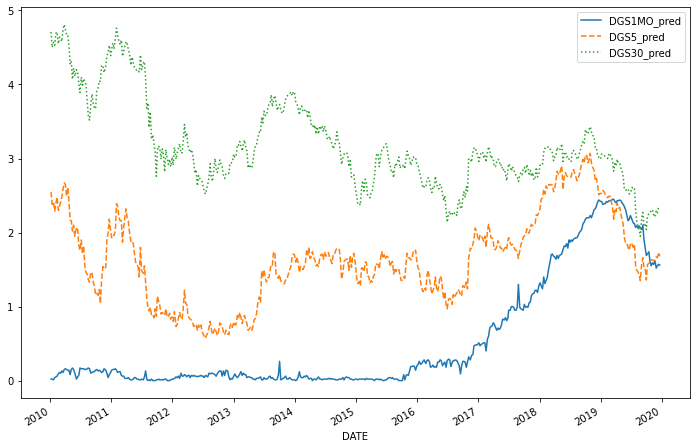

In [14]:
Y.plot(style=['-', '--', ':'], figsize=(12,8))

In the plot, we see that the deviation among the short-term, medium-term and long-term rates was higher in 2010 and has bee decreasing then. There was a drop in the long-term and medium-term rates during 2011, and they also have been declining since then. The order of the rates has been in line with the tenors. However, for a few months in recent years, the 5Y rate has been lower than the 1MO rate. In the time series of all the tenors, we can see that the mean varies with time, resulting in an upward trend. Thus these series are nonstationnary time series.

In some cases, the linear regression for such nonstationnary dependent variables might not be valid. However, we are using the lagged variables, which are also nonstationnary as independent variables. So we are effectively modeling a nonstationnary time series against another nonstationnary time series, which might still be valid.

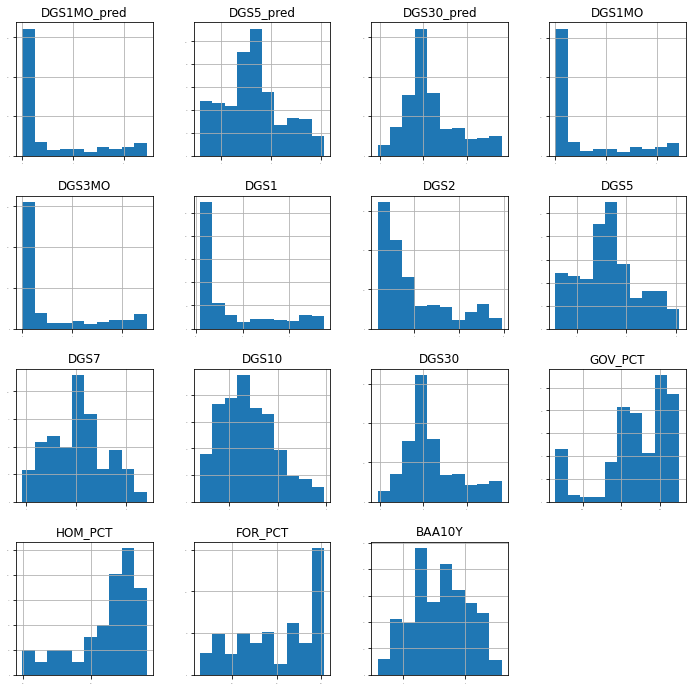

In [15]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

<Figure size 1080x1080 with 0 Axes>

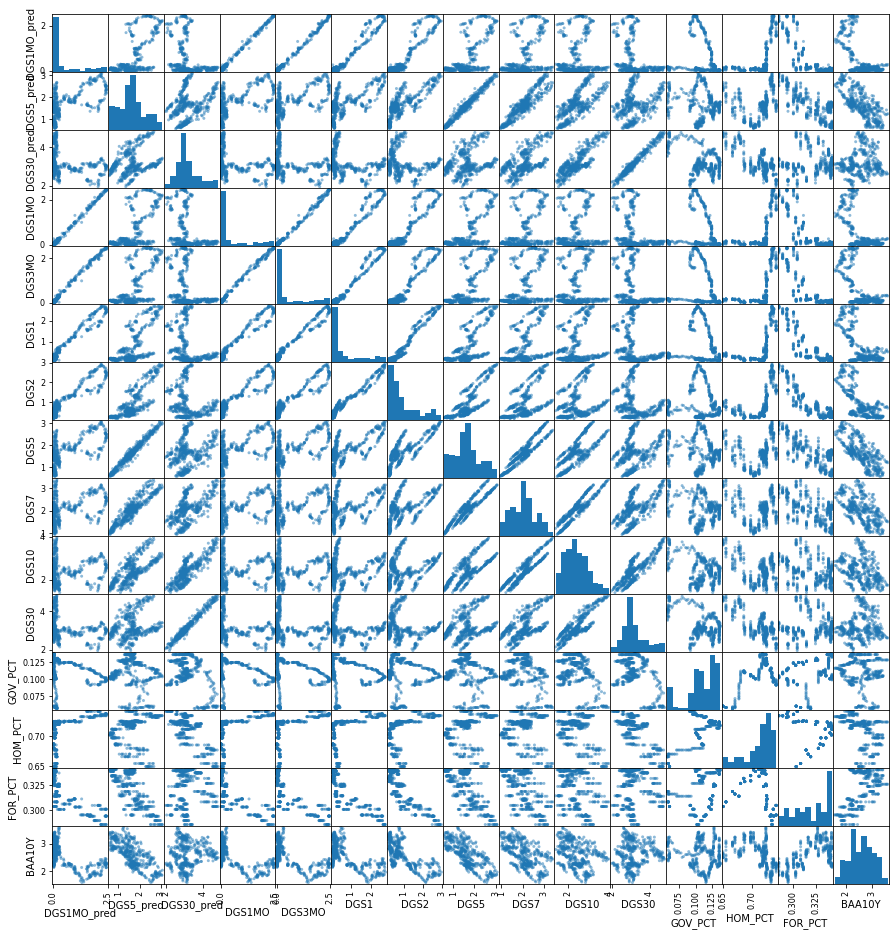

In [19]:
# Scatterplot Matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(15,16))
pyplot.show()

We see a significant linear realtionship of the predicted variables with their lags and other tenors of the yield curve. There is also a linear relationship, with negative slope between 1MO, 5Y rates versus corporate spread and changes in foreign government purchases. The 30Y rate shows a linear relationship with these variables, although the slope is negative. Overall, we see a lot of linear relationships, and we expect the linear models to perfom well.

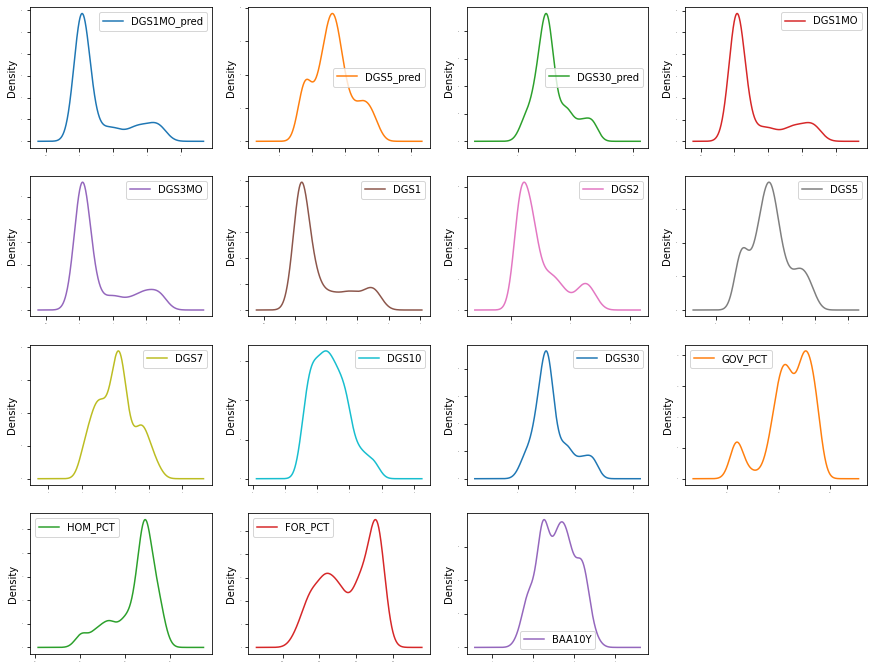

In [16]:
# density
dataset.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

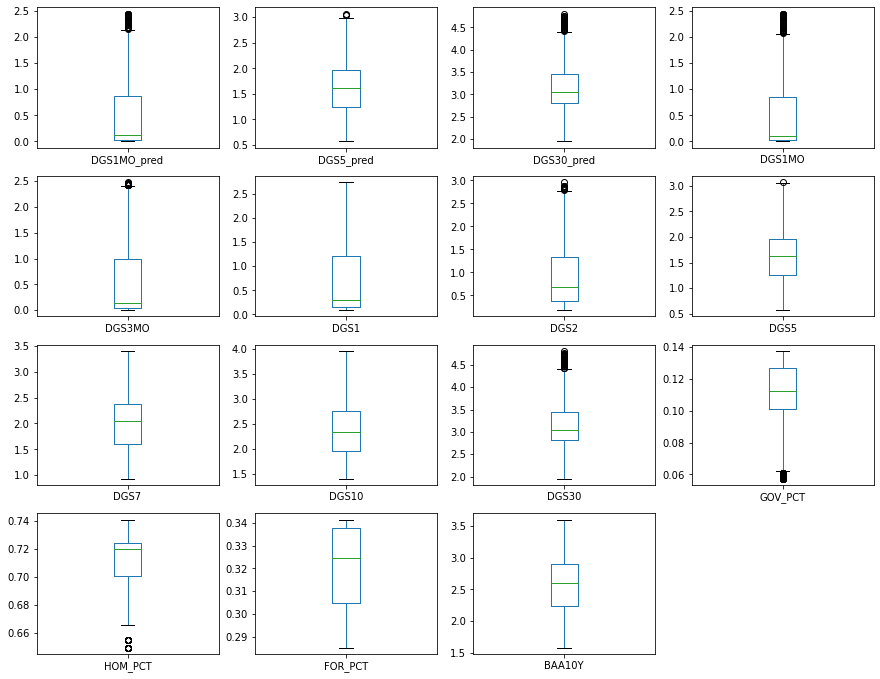

In [17]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

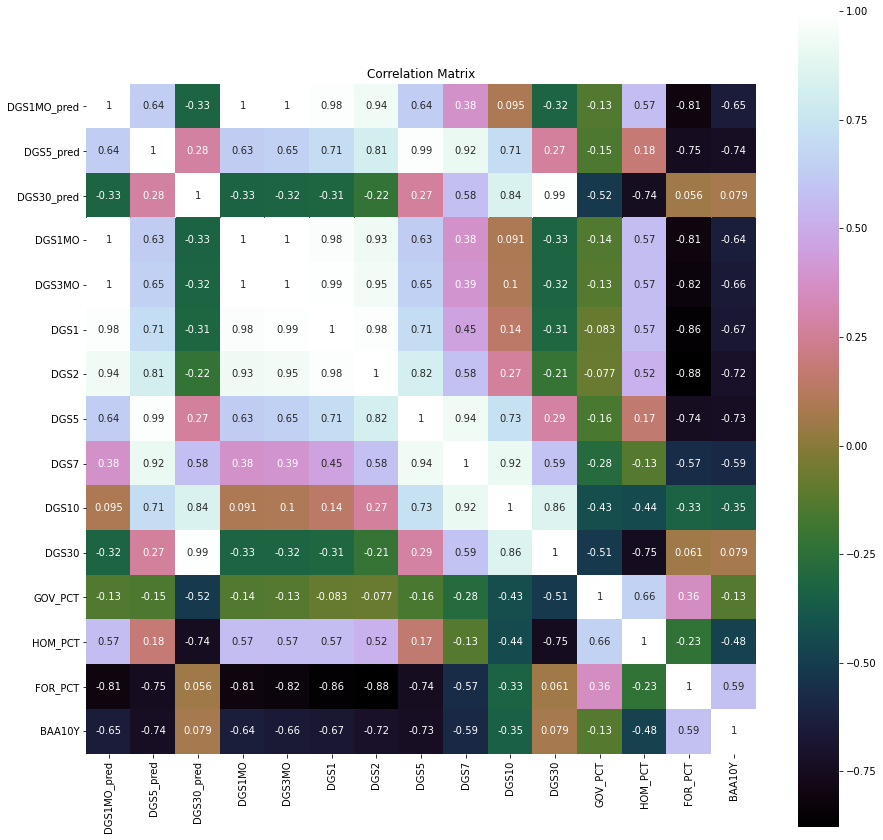

In [18]:
# correlation
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

### 3.3. Time Series Analysis

#### 1 month

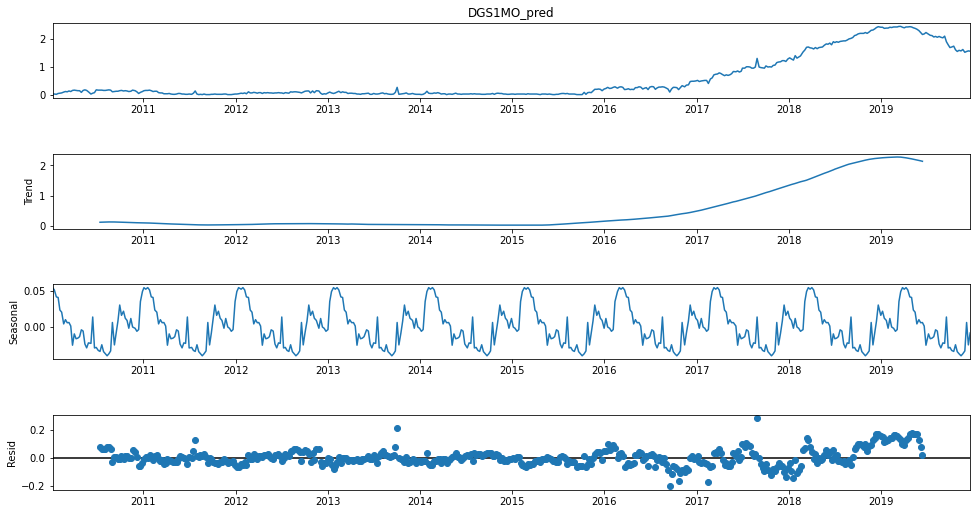

In [20]:
temp_Y = dataset['DGS1MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 5Y

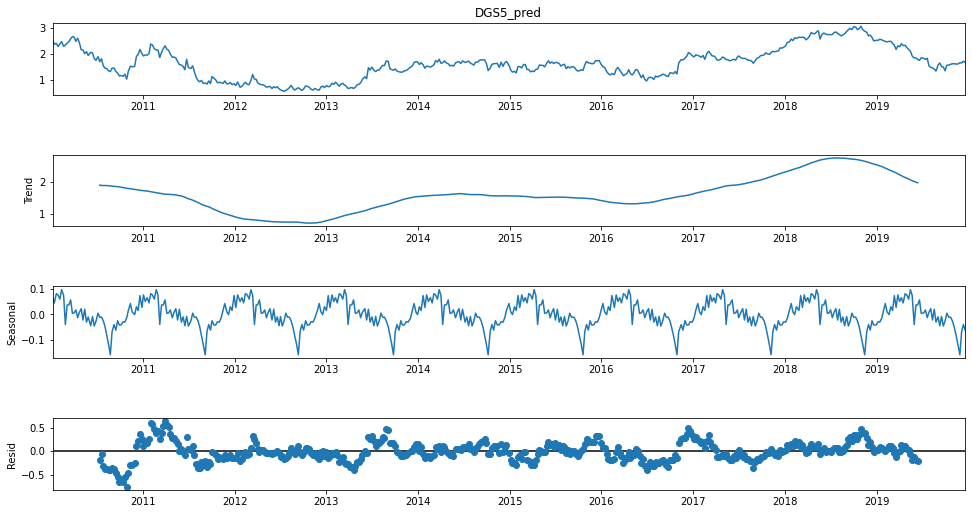

In [21]:
temp_Y = dataset['DGS5_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 30Y

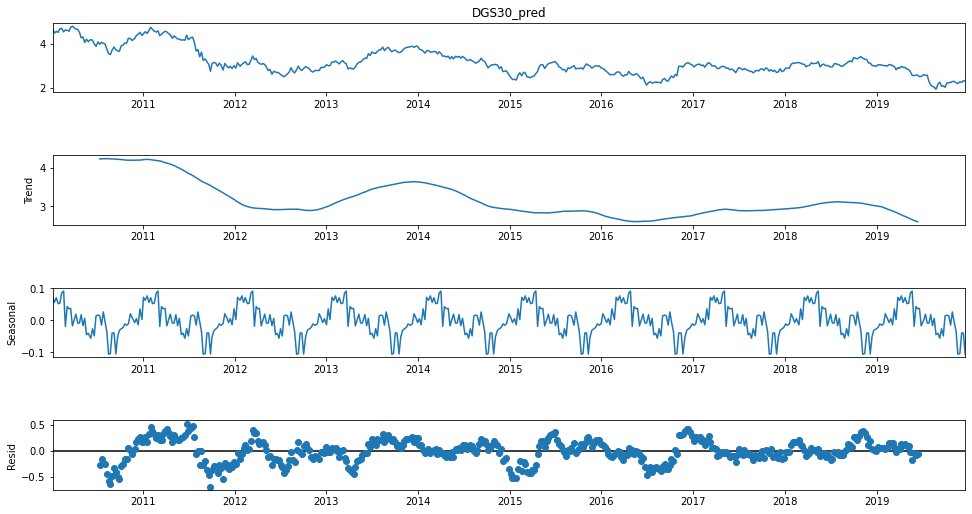

In [22]:
temp_Y = dataset['DGS30_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Around Q1 2018, we observe a trend decrease in the 1 Month, 5 year and 30 year. However, the trend is most pronounced in the 1 month series.

## 4. Data Preparation and analysis

In [23]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10,'Score'))  #print 10 best features
    print('--------------')

DGS1MO_pred
      Specs       Score
0    DGS1MO  152439.908
1    DGS3MO  100295.080
2      DGS1   11167.924
3      DGS2    3504.919
10  FOR_PCT     956.164
11   BAA10Y     358.381
4      DGS5     343.804
9   HOM_PCT     241.461
5      DGS7      85.943
7     DGS30      58.712
--------------
DGS5_pred
      Specs      Score
4      DGS5  16556.415
5      DGS7   2719.264
3      DGS2    974.020
10  FOR_PCT    629.036
11   BAA10Y    591.248
6     DGS10    517.782
2      DGS1    506.494
1    DGS3MO    364.670
0    DGS1MO    328.479
7     DGS30     39.453
--------------
DGS30_pred
     Specs      Score
7    DGS30  17012.132
6    DGS10   1231.019
9  HOM_PCT    625.166
5     DGS7    251.664
8  GOV_PCT    181.667
0   DGS1MO     60.893
1   DGS3MO     59.270
2     DGS1     54.492
4     DGS5     40.600
3     DGS2     25.317
--------------


As expected, based on the univariate feature selection, all the time series are most dependent on the previous changes.


## 5. Evaluate Algorithms and Models

### 5.1. Train Test Split and evaluation metrics

In [24]:
# split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [25]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'

### 5.2. Compare Models and Algorithms

In [26]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [27]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.007920808754006126 
Std CV Error: (0.0024548490704607876) 
Training Error:
DGS1MO_pred    0.002
DGS5_pred      0.010
DGS30_pred     0.010
dtype: float64 
Test Error:
DGS1MO_pred    0.001
DGS5_pred      0.009
DGS30_pred     0.010
dtype: float64
----------
LASSO: 
Average CV error: 0.43997675286482785 
Std CV Error: (0.057858594865567645) 
Training Error:
DGS1MO_pred    0.573
DGS5_pred      0.353
DGS30_pred     0.386
dtype: float64 
Test Error:
DGS1MO_pred    0.742
DGS5_pred      0.350
DGS30_pred     0.320
dtype: float64
----------
EN: 
Average CV error: 0.40206790167948475 
Std CV Error: (0.054982899133936634) 
Training Error:
DGS1MO_pred    0.456
DGS5_pred      0.353
DGS30_pred     0.386
dtype: float64 
Test Error:
DGS1MO_pred    0.592
DGS5_pred      0.350
DGS30_pred     0.320
dtype: float64
----------
KNN: 
Average CV error: 0.00918559617886179 
Std CV Error: (0.003072853113875062) 
Training Error:
DGS1MO_pred    0.001
DGS5_pred      0.008
DGS30_pred     0.007

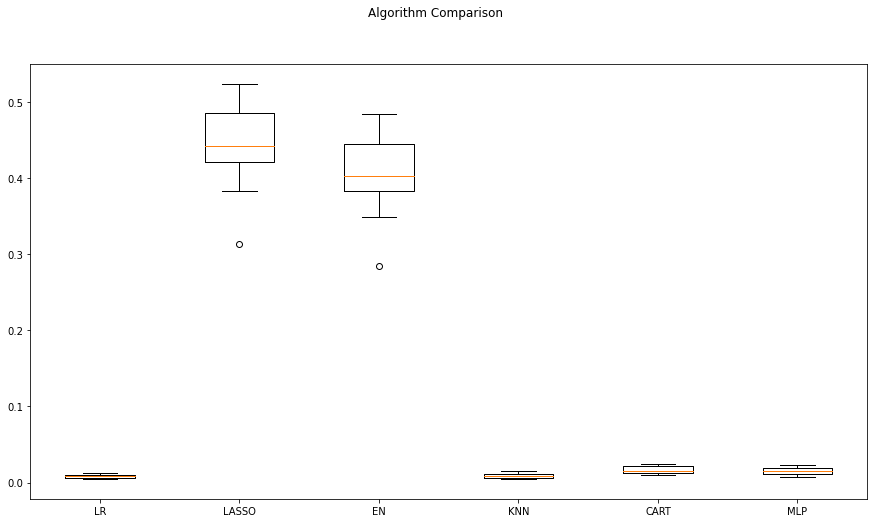

In [28]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

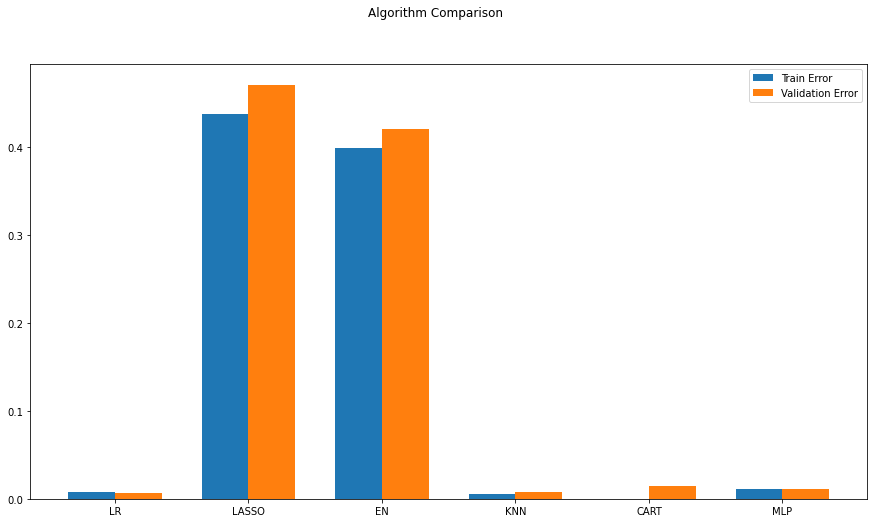

In [29]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the training and test error, we see a good performance of the linear regression model. We see that lasso and elastic net perform poorly. These are regularized regression models, and they reduce the number of variables in case they are not important. a decrease in the number of variables might have caused a loss of information leading to poor model performance. 

KNN and CART are good, but looking closely, we see that the test errors are higher than the training error. 

We also see that the performance of the artificial neural network (MLP) algorithm is comparable to lthe linear regression model. Despite its simplicity, the linear regression is a tough benchmark to beat for one-step-ahead forecasting when there is a significant linear relatonship between the variables.

## 6. Model Tuning and Grid Search

In [31]:
# 7. Grid search : MLPRegressor 
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.018486 using {'hidden_layer_sizes': (20, 30, 20)}
-0.031424 (0.012569) with: {'hidden_layer_sizes': (20,)}
-0.023989 (0.005145) with: {'hidden_layer_sizes': (50,)}
-0.023308 (0.006474) with: {'hidden_layer_sizes': (20, 20)}
-0.018486 (0.007236) with: {'hidden_layer_sizes': (20, 30, 20)}


## 7. Finalise the Model

In [32]:
# prepare model
model = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
model.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

### 7.1. Results and comparison of Regression and MLP

In [35]:
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

# prepare model
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)

mse_OLS = mean_squared_error(Y_validation, predictions_2)
r2_OLS = r2_score(Y_validation, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP ))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP ))

MSE Regression = 0.006778, MSE MLP = 0.016365
R2 Regression = 0.979827, R2 MLP = 0.951171


The statistics of MLP and Linear regression are comparable. Let us check the prediction shape on the validation set.


### Predictions -        LR-MLP


In [36]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

<AxesSubplot:xlabel='DATE'>

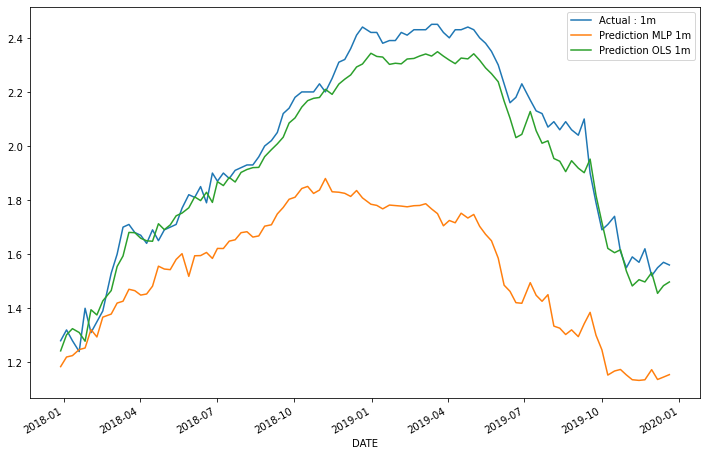

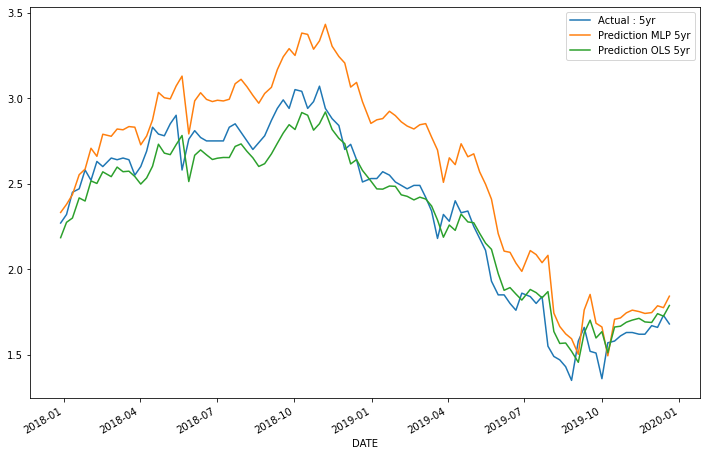

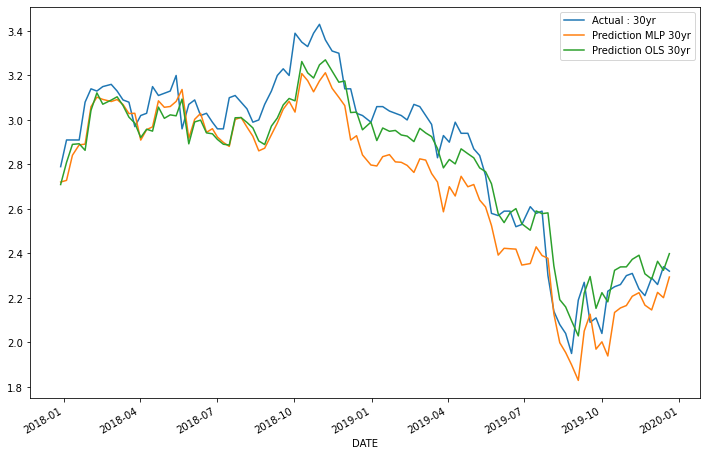

In [38]:
pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(12,8))

pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(12,8))

pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(12,8))

Looking at the charts above, we see that the predictions of the linear regression and ANN are comparable. For 1MO tenor, the fitting with ANN is slightly poor compared to the linear regression. However, for 5Y and 30Y tenors the ANN performs as well as the linear regression model. Plus, the multitask learning with neural network is more intuitive for modeling many time series simultaneously.

## Conclusion

In this case study, we applied supervised regression to the prediction of several tenors of yield curve. The linear regression model, despite its simplicity, is a tough benchmark to beat for such one-ste-ahead forecasting, given the dominant characteristic of the last available value of the variable to predict. The ANN results in this case study are comparable to the linear regression models. An additional benefit of ANN is that it is more flexible to changing market conditions. Also, ANN models can be enhanced by performing grid search on several other hyperparameters and the option of incorporating recurrent neural networks (RNN), such as long short-term memory (LSTM).

Overall, we built a machine learning-based model using 1NN with an encouraging outcome, in the context of fixed income instruments. this allows us to perform predictions using historical data to generate results and analyze risk and profitability bfore risking any actual capital in the fixed income market.